# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version = '20'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data='snow'

fname1=mdir+edir+'icebox_train_rc_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 2528737)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 10:06:20 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    qi   = xr.open_dataset(fname).q_ice.values
    ni   = xr.open_dataset(fname).n_ice.values
    qs   = xr.open_dataset(fname).q_snow.values
    ns   = xr.open_dataset(fname).n_snow.values
    cwc  = xr.open_dataset(fname).cwc.values
    # process rates
    aggr_ice_snow_num  = xr.open_dataset(fname).aggr_ice_snow_num.values
    aggr_ice_snow_mass = xr.open_dataset(fname).aggr_ice_snow_mass.values
    # some numerical lower bounds
    q_min = 1e-12
    n_min = 1e-12
    z_min = 1e-20
    p_min = 1e-20
    # transform everything in log space
    ni = np.log(ni, where=ni>n_min, out=np.nan*ni)
    qi = np.log(qi, where=qi>q_min, out=np.nan*qi)
    ns = np.log(ns, where=ns>n_min, out=np.nan*ns)
    qs = np.log(qs, where=qs>q_min, out=np.nan*qs)
    aggr_ice_snow_num  = np.log(aggr_ice_snow_num,  where=aggr_ice_snow_num>p_min,  out=np.nan*aggr_ice_snow_num)    
    aggr_ice_snow_mass = np.log(aggr_ice_snow_mass, where=aggr_ice_snow_mass>p_min, out=np.nan*aggr_ice_snow_mass)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ qi, ni, qs, ns, temp, rho, aggr_ice_snow_num, aggr_ice_snow_mass ]))
    dataset = dataset.T
    dataset.columns = [ 'qi', 'ni', 'qs', 'ns', 'temp', 'rho', 'aggr_ice_snow_num', 'aggr_ice_snow_mass' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


### Separate in training, validation and test data 70/15/15

In [8]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [9]:
dataset_train.head()

qi         ni         qs        ns        temp    rho  \
4 -9.112307  11.609235 -11.862312  7.424165  243.929993  0.702   
5 -9.115394  11.605140 -11.743698  7.545390  244.000000  0.703   
6 -9.117306  11.601485 -11.652694  7.640123  244.070007  0.704   
7 -9.120774  11.597083 -11.550067  7.738924  244.139999  0.705   
8 -9.122513  11.593030 -11.475919  7.819234  244.220001  0.706   

   aggr_ice_snow_num  aggr_ice_snow_mass  
4          -1.609438          -22.464043  
5           0.000000          -21.088255  
6           0.336472          -20.243795  
7           0.788457          -20.463991  
8           0.000000          -20.848640

In [10]:
dataset_test.head()

qi         ni         qs        ns        temp    rho  \
2  -9.102742  11.618186 -12.225215  7.100027  243.779999  0.700   
3  -9.107783  11.613495 -12.022685  7.286192  243.850006  0.701   
10 -9.128576  11.584595 -11.316619  7.971086  244.360001  0.708   
11 -9.130421  11.581051 -11.255651  8.026824  244.440002  0.709   
14 -9.136811  11.568360 -11.083484  8.199189  244.660004  0.712   

    aggr_ice_snow_num  aggr_ice_snow_mass  
2           -0.223144          -20.391813  
3           -0.223144          -19.928432  
10           0.182322          -20.773163  
11           0.182322          -20.392567  
14           0.587787          -21.291788

In [11]:
dataset_train.describe()

qi            ni            qs            ns          temp  \
count  1.539362e+06  1.539362e+06  1.539362e+06  1.539362e+06  1.539362e+06   
mean  -9.376831e+00  1.363657e+01 -8.319955e+00  1.128078e+01  2.403648e+02   
std    3.281059e+00  3.687391e+00  1.768667e+00  2.362565e+00  1.191474e+01   
min   -2.762942e+01 -6.242596e+00 -2.297326e+01 -8.959037e+00  2.069000e+02   
25%   -9.663806e+00  1.213183e+01 -9.501184e+00  1.041572e+01  2.318500e+02   
50%   -8.643721e+00  1.407910e+01 -8.263171e+00  1.167640e+01  2.407300e+02   
75%   -7.598211e+00  1.606142e+01 -7.019137e+00  1.280606e+01  2.484900e+02   
max   -4.315790e+00  2.052169e+01 -4.012175e+00  1.607404e+01  2.737500e+02   

                rho  aggr_ice_snow_num  aggr_ice_snow_mass  
count  1.539362e+06       1.539362e+06        1.539362e+06  
mean   6.735823e-01       4.745755e+00       -1.820503e+01  
std    1.423216e-01       3.184195e+00        3.031325e+00  
min    4.120000e-01      -1.680119e+01       -4.400813e+01  
25%    5.650000e-01       3.186353e+00       -1.955183e+01  
50%    6.650000e-01       4.774069e+00       -1.787265e+01  
75%    7.610000e-01       6.717211e+00       -1.635845e+01  
max    1.237000e+00       1.533681e+01       -9.099184e+00

In [12]:
dataset_test.describe()

qi             ni             qs             ns  \
count  329296.000000  329296.000000  329296.000000  329296.000000   
mean       -9.370995      13.642250      -8.324343      11.281565   
std         3.272566       3.680648       1.769959       2.361666   
min       -27.627428      -6.237621     -23.015108      -8.477780   
25%        -9.658559      12.134040      -9.509222      10.416491   
50%        -8.644913      14.079949      -8.265948      11.677507   
75%        -7.599179      16.068151      -7.017442      12.803156   
max        -4.386356      20.521088      -4.012285      15.974710   

                temp            rho  aggr_ice_snow_num  aggr_ice_snow_mass  
count  329296.000000  329296.000000      329296.000000       329296.000000  
mean      240.352066       0.673510           4.744178          -18.206320  
std        11.886750       0.142022           3.184407            3.030387  
min       206.830002       0.412000         -16.801191          -43.901291  
25%       231.860001       0.565000           3.194583          -19.554352  
50%       240.720001       0.665000           4.769625          -17.874203  
75%       248.449997       0.760000           6.708328          -16.360722  
max       273.589996       1.246000          15.261765           -9.224283

In [13]:
dataset_val.describe()

qi             ni             qs             ns  \
count  330372.000000  330372.000000  330372.000000  330372.000000   
mean       -9.371466      13.642366      -8.321676      11.283075   
std         3.275283       3.679963       1.767712       2.360374   
min       -27.629622      -6.239618     -22.753004      -8.383668   
25%        -9.656002      12.144941      -9.507615      10.420598   
50%        -8.641850      14.086835      -8.269240      11.676404   
75%        -7.599244      16.059717      -7.018866      12.807468   
max        -4.419023      20.517300      -4.012285      15.985855   

                temp            rho  aggr_ice_snow_num  aggr_ice_snow_mass  
count  330372.000000  330372.000000      330372.000000       330372.000000  
mean      240.369720       0.673604           4.748993          -18.202127  
std        11.886373       0.142067           3.179874            3.027239  
min       207.179993       0.412000         -16.801191          -43.286350  
25%       231.899994       0.566000           3.186353          -19.558999  
50%       240.729996       0.665000           4.774069          -17.871026  
75%       248.449997       0.761000           6.723833          -16.357038  
max       273.609985       1.222000          15.175823           -9.350888

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['qi'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['qs'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['temp'] > 273 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

qi            ni            qs            ns          temp  \
count  1.497110e+06  1.497110e+06  1.497110e+06  1.497110e+06  1.497110e+06   
mean  -9.007777e+00  1.398807e+01 -8.383289e+00  1.146925e+01  2.397537e+02   
std    2.417765e+00  3.030139e+00  1.735426e+00  2.083603e+00  1.146491e+01   
min   -1.999998e+01  1.264564e-01 -1.999915e+01 -8.381483e+00  2.069000e+02   
25%   -9.528863e+00  1.230687e+01 -9.537609e+00  1.055012e+01  2.315400e+02   
50%   -8.593427e+00  1.417994e+01 -8.323479e+00  1.173631e+01  2.403200e+02   
75%   -7.564609e+00  1.611920e+01 -7.123638e+00  1.284090e+01  2.477800e+02   
max   -4.315790e+00  2.052169e+01 -4.013613e+00  1.607404e+01  2.730000e+02   

                rho  aggr_ice_snow_num  aggr_ice_snow_mass  
count  1.497110e+06       1.497110e+06        1.497110e+06  
mean   6.655651e-01       5.016510e+00       -1.791914e+01  
std    1.349469e-01       2.729575e+00        2.473662e+00  
min    4.120000e-01      -1.680119e+01       -4.074984e+01  
25%    5.620000e-01       3.242592e+00       -1.938074e+01  
50%    6.610000e-01       4.852030e+00       -1.779572e+01  
75%    7.510000e-01       6.783552e+00       -1.630684e+01  
max    1.235000e+00       1.533681e+01       -9.099184e+00

In [17]:
dataset_test.describe()

qi             ni             qs             ns  \
count  320229.000000  320229.000000  320229.000000  320229.000000   
mean       -9.001336      13.994225      -8.387945      11.471392   
std         2.405882       3.022491       1.735754       2.076988   
min       -19.999493       0.461152     -19.905294      -7.918494   
25%        -9.525626      12.310568      -9.546974      10.552735   
50%        -8.594182      14.181056      -8.326862      11.738067   
75%        -7.565805      16.125269      -7.123837      12.837185   
max        -4.386356      20.521088      -4.013890      15.974710   

                temp            rho  aggr_ice_snow_num  aggr_ice_snow_mass  
count  320229.000000  320229.000000      320229.000000       320229.000000  
mean      239.740784       0.665483           5.015967          -17.919561  
std        11.437246       0.134638           2.727801            2.469907  
min       206.830002       0.412000         -16.801191          -41.798306  
25%       231.550003       0.562000           3.242592          -19.384136  
50%       240.320007       0.660000           4.852030          -17.798685  
75%       247.729996       0.751000           6.770790          -16.308826  
max       273.000000       1.212000          15.261765           -9.224283

### Pairplot

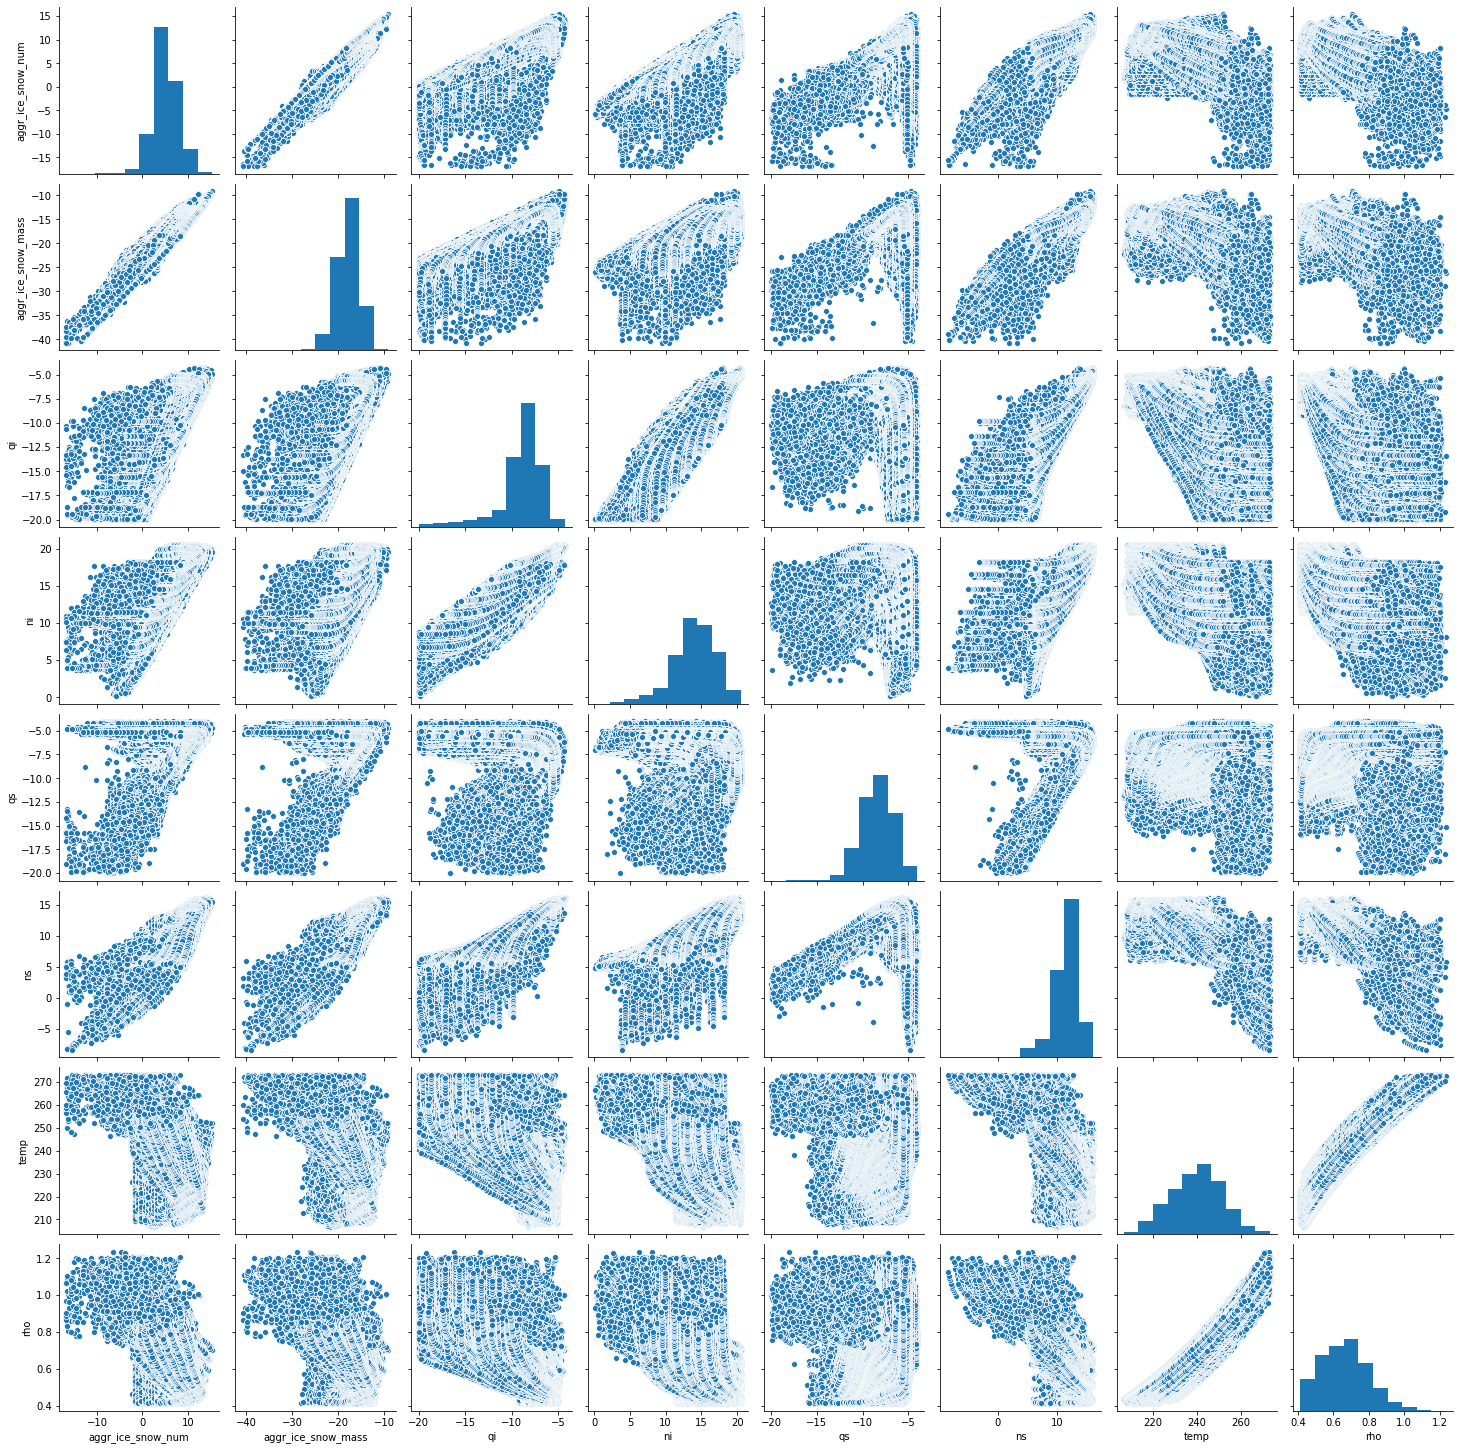

In [18]:
sns.pairplot(dataset_train[["aggr_ice_snow_num","aggr_ice_snow_mass","qi","ni","qs","ns","temp","rho"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [19]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [20]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [21]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [22]:
train_dataset1 = train_dataset1.drop(['temp','rho'], axis=1)
train_dataset2 = train_dataset2.drop(['rho'], axis=1)
#train_dataset3 = train_dataset3.drop(['rho'], axis=1)

In [23]:
test_dataset1 = test_dataset1.drop(['temp','rho'], axis=1)
test_dataset2 = test_dataset2.drop(['rho'], axis=1)
#test_dataset3 = test_dataset3.drop(['rho'], axis=1)

In [24]:
val_dataset1 = val_dataset1.drop(['temp','rho'], axis=1)
val_dataset2 = val_dataset2.drop(['rho'], axis=1)
#val_dataset3 = val_dataset3.drop(['rho'], axis=1)

In [25]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("aggr_ice_snow_num")
train_stats1.pop("aggr_ice_snow_mass")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%  \
qi  1497110.0  -9.007777  2.417765 -19.999977  -9.528863  -8.593427   
ni  1497110.0  13.988068  3.030139   0.126456  12.306868  14.179945   
qs  1497110.0  -8.383289  1.735426 -19.999153  -9.537609  -8.323479   
ns  1497110.0  11.469252  2.083603  -8.381483  10.550119  11.736309   

          75%        max  
qi  -7.564609  -4.315790  
ni  16.119196  20.521688  
qs  -7.123638  -4.013613  
ns  12.840902  16.074039

In [26]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("aggr_ice_snow_num")
train_stats2.pop("aggr_ice_snow_mass")
train_stats2 = train_stats2.transpose()
train_stats2

count        mean        std         min         25%         50%  \
qi    1497110.0   -9.007777   2.417765  -19.999977   -9.528863   -8.593427   
ni    1497110.0   13.988068   3.030139    0.126456   12.306868   14.179945   
qs    1497110.0   -8.383289   1.735426  -19.999153   -9.537609   -8.323479   
ns    1497110.0   11.469252   2.083603   -8.381483   10.550119   11.736309   
temp  1497110.0  239.753738  11.464909  206.899994  231.539993  240.320007   

             75%         max  
qi     -7.564609   -4.315790  
ni     16.119196   20.521688  
qs     -7.123638   -4.013613  
ns     12.840902   16.074039  
temp  247.779999  273.000000

In [27]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("aggr_ice_snow_num")
train_stats3.pop("aggr_ice_snow_mass")
train_stats3 = train_stats3.transpose()
train_stats3

count        mean        std         min         25%         50%  \
qi    1497110.0   -9.007777   2.417765  -19.999977   -9.528863   -8.593427   
ni    1497110.0   13.988068   3.030139    0.126456   12.306868   14.179945   
qs    1497110.0   -8.383289   1.735426  -19.999153   -9.537609   -8.323479   
ns    1497110.0   11.469252   2.083603   -8.381483   10.550119   11.736309   
temp  1497110.0  239.753738  11.464909  206.899994  231.539993  240.320007   
rho   1497110.0    0.665565   0.134947    0.412000    0.562000    0.661000   

             75%         max  
qi     -7.564609   -4.315790  
ni     16.119196   20.521688  
qs     -7.123638   -4.013613  
ns     12.840902   16.074039  
temp  247.779999  273.000000  
rho     0.751000    1.235000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [28]:
# pop does not work for multiple columns, use copy instead

labels = ['aggr_ice_snow_num','aggr_ice_snow_mass']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [29]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [30]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [31]:
train_labels.describe()

aggr_ice_snow_num  aggr_ice_snow_mass
count       1.497110e+06        1.497110e+06
mean        5.016510e+00       -1.791914e+01
std         2.729575e+00        2.473662e+00
min        -1.680119e+01       -4.074984e+01
25%         3.242592e+00       -1.938074e+01
50%         4.852030e+00       -1.779572e+01
75%         6.783552e+00       -1.630684e+01
max         1.533681e+01       -9.099184e+00

In [32]:
train_dataset1.describe()

qi            ni            qs            ns
count  1.497110e+06  1.497110e+06  1.497110e+06  1.497110e+06
mean  -9.007777e+00  1.398807e+01 -8.383289e+00  1.146925e+01
std    2.417765e+00  3.030139e+00  1.735426e+00  2.083603e+00
min   -1.999998e+01  1.264564e-01 -1.999915e+01 -8.381483e+00
25%   -9.528863e+00  1.230687e+01 -9.537609e+00  1.055012e+01
50%   -8.593427e+00  1.417994e+01 -8.323479e+00  1.173631e+01
75%   -7.564609e+00  1.611920e+01 -7.123638e+00  1.284090e+01
max   -4.315790e+00  2.052169e+01 -4.013613e+00  1.607404e+01

In [33]:
train_dataset2.describe()

qi            ni            qs            ns          temp
count  1.497110e+06  1.497110e+06  1.497110e+06  1.497110e+06  1.497110e+06
mean  -9.007777e+00  1.398807e+01 -8.383289e+00  1.146925e+01  2.397537e+02
std    2.417765e+00  3.030139e+00  1.735426e+00  2.083603e+00  1.146491e+01
min   -1.999998e+01  1.264564e-01 -1.999915e+01 -8.381483e+00  2.069000e+02
25%   -9.528863e+00  1.230687e+01 -9.537609e+00  1.055012e+01  2.315400e+02
50%   -8.593427e+00  1.417994e+01 -8.323479e+00  1.173631e+01  2.403200e+02
75%   -7.564609e+00  1.611920e+01 -7.123638e+00  1.284090e+01  2.477800e+02
max   -4.315790e+00  2.052169e+01 -4.013613e+00  1.607404e+01  2.730000e+02

In [34]:
train_dataset3.describe()

qi            ni            qs            ns          temp  \
count  1.497110e+06  1.497110e+06  1.497110e+06  1.497110e+06  1.497110e+06   
mean  -9.007777e+00  1.398807e+01 -8.383289e+00  1.146925e+01  2.397537e+02   
std    2.417765e+00  3.030139e+00  1.735426e+00  2.083603e+00  1.146491e+01   
min   -1.999998e+01  1.264564e-01 -1.999915e+01 -8.381483e+00  2.069000e+02   
25%   -9.528863e+00  1.230687e+01 -9.537609e+00  1.055012e+01  2.315400e+02   
50%   -8.593427e+00  1.417994e+01 -8.323479e+00  1.173631e+01  2.403200e+02   
75%   -7.564609e+00  1.611920e+01 -7.123638e+00  1.284090e+01  2.477800e+02   
max   -4.315790e+00  2.052169e+01 -4.013613e+00  1.607404e+01  2.730000e+02   

                rho  
count  1.497110e+06  
mean   6.655651e-01  
std    1.349469e-01  
min    4.120000e-01  
25%    5.620000e-01  
50%    6.610000e-01  
75%    7.510000e-01  
max    1.235000e+00

### Normalize the features

In [35]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)

In [36]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
qi  1497110.0  3.784915e-08  1.0 -4.546430 -0.215524  0.171378  0.596902   
ni  1497110.0  4.856191e-07  1.0 -4.574579 -0.554826  0.063323  0.703310   
qs  1497110.0  9.282611e-08  1.0 -6.693378 -0.665151  0.034465  0.725846   
ns  1497110.0  1.344848e-06  1.0 -9.527119 -0.441126  0.128171  0.658307   

         max  
qi  1.940630  
ni  2.156212  
qs  2.517927  
ns  2.210012

In [37]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std       min       25%       50%       75%  \
qi    1497110.0  3.784915e-08  1.0 -4.546430 -0.215524  0.171378  0.596902   
ni    1497110.0  4.856191e-07  1.0 -4.574579 -0.554826  0.063323  0.703310   
qs    1497110.0  9.282611e-08  1.0 -6.693378 -0.665151  0.034465  0.725846   
ns    1497110.0  1.344848e-06  1.0 -9.527119 -0.441126  0.128171  0.658307   
temp  1497110.0 -5.976209e-06  1.0 -2.865591 -0.716425  0.049391  0.700072   

           max  
qi    1.940630  
ni    2.156212  
qs    2.517927  
ns    2.210012  
temp  2.899828

In [38]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean  std       min       25%       50%       75%  \
qi    1497110.0  3.784915e-08  1.0 -4.546430 -0.215524  0.171378  0.596902   
ni    1497110.0  4.856191e-07  1.0 -4.574579 -0.554826  0.063323  0.703310   
qs    1497110.0  9.282611e-08  1.0 -6.693378 -0.665151  0.034465  0.725846   
ns    1497110.0  1.344848e-06  1.0 -9.527119 -0.441126  0.128171  0.658307   
temp  1497110.0 -5.976209e-06  1.0 -2.865591 -0.716425  0.049391  0.700072   
rho   1497110.0 -6.056717e-07  1.0 -1.878999 -0.767451 -0.033829  0.633100   

           max  
qi    1.940630  
ni    2.156212  
qs    2.517927  
ns    2.210012  
temp  2.899828  
rho   4.219696

### Normalize the labels

In [39]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count       mean       std        min        25%  \
aggr_ice_snow_num   1497110.0   5.016510  2.729575 -16.801191   3.242592   
aggr_ice_snow_mass  1497110.0 -17.919144  2.473662 -40.749840 -19.380744   

                          50%        75%        max  
aggr_ice_snow_num    4.852030   6.783552  15.336810  
aggr_ice_snow_mass -17.795724 -16.306837  -9.099184

In [40]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [41]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [42]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(4,16,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 658
Trainable params: 658
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [44]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.30061802, -0.8457851 ],
       [-0.30039567, -0.8456639 ],
       [-0.30021557, -0.8455624 ],
       [-0.30001402, -0.8454541 ],
       [-0.29985267, -0.84535766],
       [-0.29965416, -0.845249  ],
       [-0.2992689 , -0.84502506],
       [-0.29911694, -0.84493554],
       [-0.2987215 , -0.8447031 ],
       [-0.29858932, -0.84462166]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [45]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# width of neural net
nsize = 16

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [46]:
activ = "sigm"
model1 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0458,  mae:0.1331,  mse:0.0458,  val_loss:0.0275,  val_mae:0.1073,  val_mse:0.0275,  
.......................................

Text(0, 0.5, 'MAE')

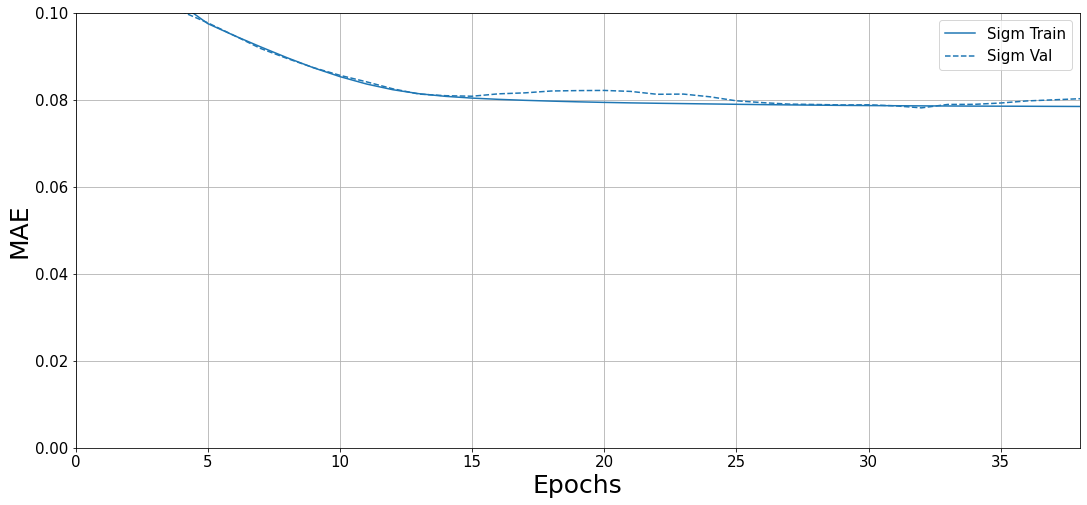

In [47]:
histories['sigm'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0, 0.1])
plt.ylabel('MAE')

In [48]:
activ = "ReLU"
model2 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0273,  mae:0.0976,  mse:0.0273,  val_loss:0.0205,  val_mae:0.0812,  val_mse:0.0205,  
....................................

Text(0, 0.5, 'MAE')

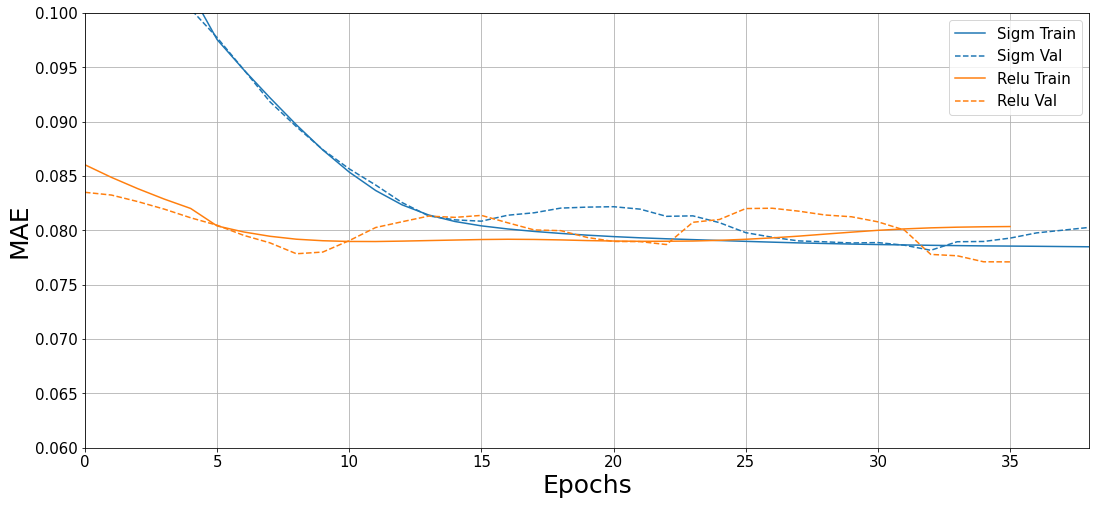

In [50]:
histories['ReLU'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.06, 0.1])
plt.ylabel('MAE')

In [51]:
activ = "ReLU_Adam"
model3 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0266,  mae:0.0981,  mse:0.0266,  val_loss:0.0209,  val_mae:0.0818,  val_mse:0.0209,  
.......................................

Text(0, 0.5, 'MAE')

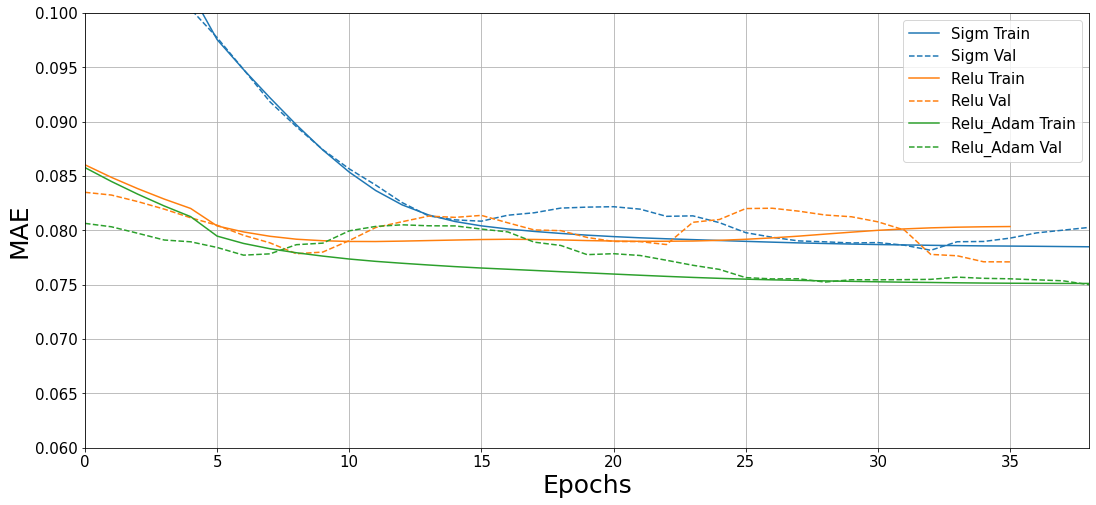

In [52]:
histories['ReLU_Adam'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.06, 0.1])
plt.ylabel('MAE')

In [53]:
nsize = 32
activ = "ReLU_Adam"
model4 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history4 = model4.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0231,  mae:0.0894,  mse:0.0231,  val_loss:0.0202,  val_mae:0.0790,  val_mse:0.0202,  
........................

Text(0, 0.5, 'MAE')

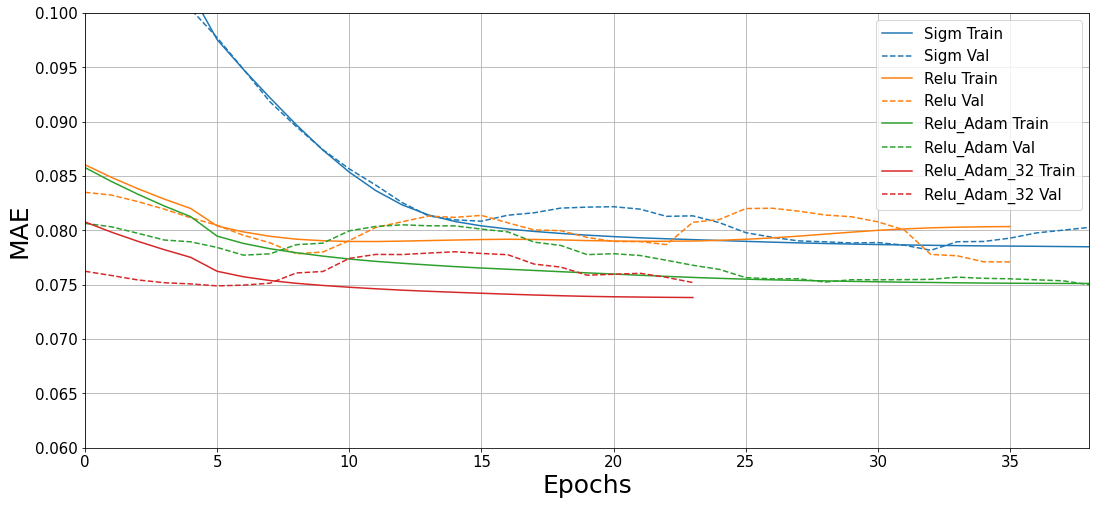

In [54]:
histories['ReLU_Adam_32'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.06, 0.1])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

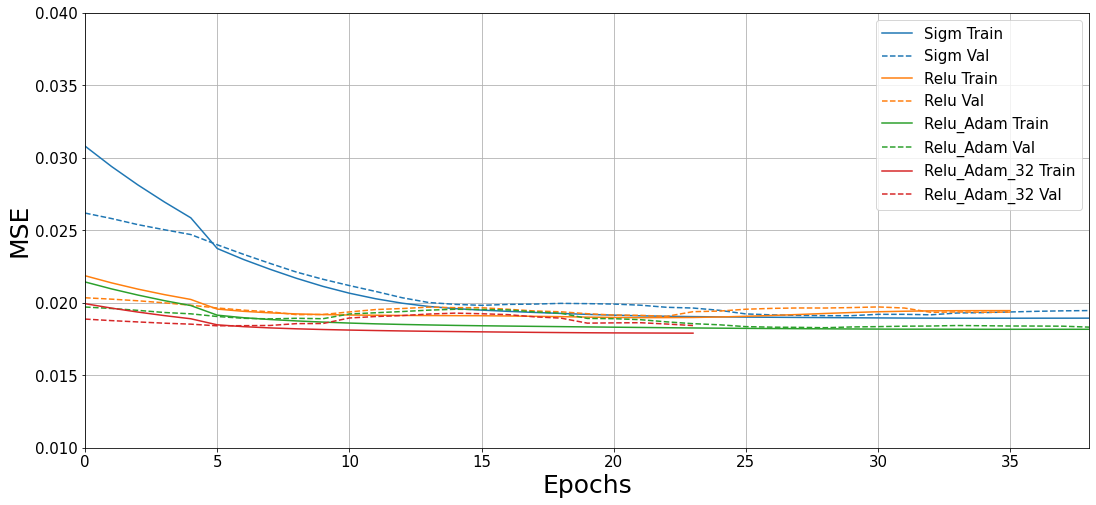

In [56]:
plotter.plot(histories, metric = "mse")
plt.ylim([0.01, 0.04])
plt.ylabel('MSE')

In [57]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

320229/320229 - 7s - loss: 0.0187 - mae: 0.0768 - mse: 0.0187
Testing set for model 1, Mean Abs Error:    0.07676


In [58]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

320229/320229 - 7s - loss: 0.0184 - mae: 0.0742 - mse: 0.0184
Testing set for model 2, Mean Abs Error:              0.07424


In [59]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

320229/320229 - 7s - loss: 0.0180 - mae: 0.0733 - mse: 0.0180
Testing set for model 3, Mean Abs Error:              0.07332


In [60]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

320229/320229 - 7s - loss: 0.0179 - mae: 0.0726 - mse: 0.0179
Testing set for model 4, Mean Abs Error:              0.07258


In [61]:
mae = [ mae1, mae2, mae3, mae4 ]
mae

[0.07675988, 0.07423881, 0.07331818, 0.0725845]

In [62]:
mse = [ mse1, mse2, mse3, mse4 ]
mse

[0.01867091, 0.018446673, 0.017999906, 0.017912894]

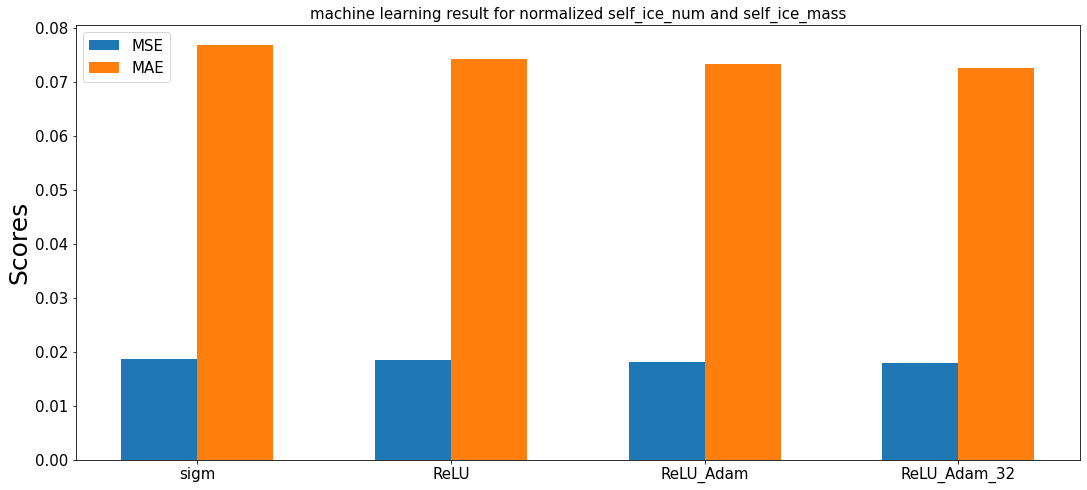

In [63]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = [ 'sigm', 'ReLU', 'ReLU_Adam', 'ReLU_Adam_32' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized self_ice_num and self_ice_mass')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [64]:
test_true_num  = np.exp(test_labels.pop('aggr_ice_snow_num'))
test_true_mass = np.exp(test_labels.pop('aggr_ice_snow_mass'))

In [65]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [66]:
p1 = pd.DataFrame(data=model1.predict(normed_test_data3), columns=["aggr_ice_snow_num", "aggr_ice_snow_mass"])

In [67]:
p1.describe()

aggr_ice_snow_num  aggr_ice_snow_mass
count      320229.000000       320229.000000
mean           -0.003130           -0.001280
std             0.977233            0.975341
min            -6.400326           -8.664460
25%            -0.629151           -0.613060
50%            -0.062359            0.045642
75%             0.630183            0.644023
max             3.465589            3.267296

In [68]:
train_labels_stats

count       mean       std        min        25%  \
aggr_ice_snow_num   1497110.0   5.016510  2.729575 -16.801191   3.242592   
aggr_ice_snow_mass  1497110.0 -17.919144  2.473662 -40.749840 -19.380744   

                          50%        75%        max  
aggr_ice_snow_num    4.852030   6.783552  15.336810  
aggr_ice_snow_mass -17.795724 -16.306837  -9.099184

In [69]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [70]:
test_predict1.describe()

aggr_ice_snow_num  aggr_ice_snow_mass
count       3.202290e+05        3.202290e+05
mean        4.154359e+03        1.688057e-07
std         2.748023e+04        7.037943e-07
min         3.903418e-06        8.120899e-18
25%         2.709085e+01        3.624147e-09
50%         1.272683e+02        1.848623e-08
75%         8.427261e+02        8.122448e-08
max         1.935923e+06        5.343968e-05

In [71]:
np.exp(test_dataset1.head())

qi             ni        qs           ns
2   0.000111  111100.000000  0.000005  1211.999878
3   0.000111  110580.039062  0.000006  1460.000366
10  0.000109  107430.000000  0.000012  2895.999512
11  0.000108  107049.953125  0.000013  3062.001221
14  0.000108  105700.015625  0.000015  3637.999268

In [72]:
test_predict1.head()

aggr_ice_snow_num  aggr_ice_snow_mass
0           0.541372        3.403303e-10
1           0.618047        4.106865e-10
2           1.124679        9.041562e-10
3           1.193187        9.762590e-10
4           1.416894        1.208685e-09

In [73]:
test_dataset2.head()

qi         ni         qs        ns        temp
2  -9.102742  11.618186 -12.225215  7.100027  243.779999
3  -9.107783  11.613495 -12.022685  7.286192  243.850006
10 -9.128576  11.584595 -11.316619  7.971086  244.360001
11 -9.130421  11.581051 -11.255651  8.026824  244.440002
14 -9.136811  11.568360 -11.083484  8.199189  244.660004

In [74]:
np.exp(test_dataset3.head())

qi             ni        qs           ns  temp       rho
2   0.000111  111100.000000  0.000005  1211.999878   inf  2.013753
3   0.000111  110580.039062  0.000006  1460.000366   inf  2.015767
10  0.000109  107430.000000  0.000012  2895.999512   inf  2.029927
11  0.000108  107049.953125  0.000013  3062.001221   inf  2.031958
14  0.000108  105700.015625  0.000015  3637.999268   inf  2.038063

In [75]:
test_predict1_num  = test_predict1['aggr_ice_snow_num']
test_predict1_mass = test_predict1['aggr_ice_snow_mass']

In [76]:

p2 = pd.DataFrame(data=model2.predict(normed_test_data3), columns=["aggr_ice_snow_num", "aggr_ice_snow_mass"])

test_predict2 = np.exp(backtransform(p2,train_labels_stats))

test_predict2_num  = test_predict2['aggr_ice_snow_num']
test_predict2_mass = test_predict2['aggr_ice_snow_mass']


### Maybe the ordering of the arrays is different? Doesn't matter for the scatter plots, but scores would be wrong

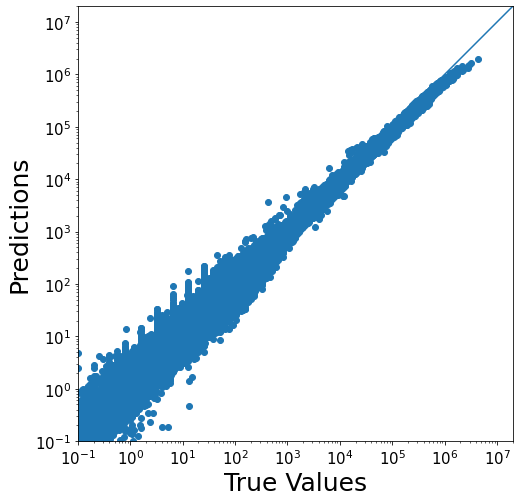

In [87]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 1e-1, 2e7

a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict1_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

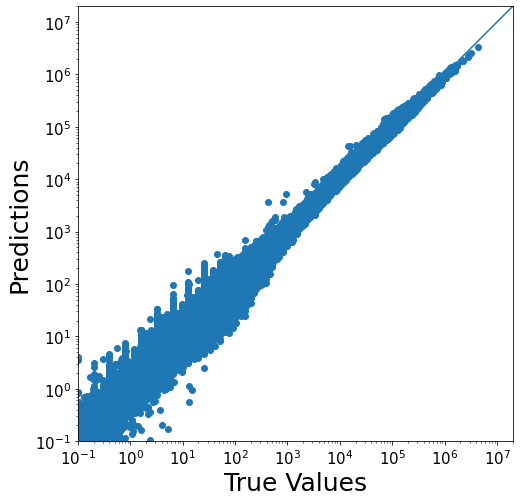

In [88]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict2_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

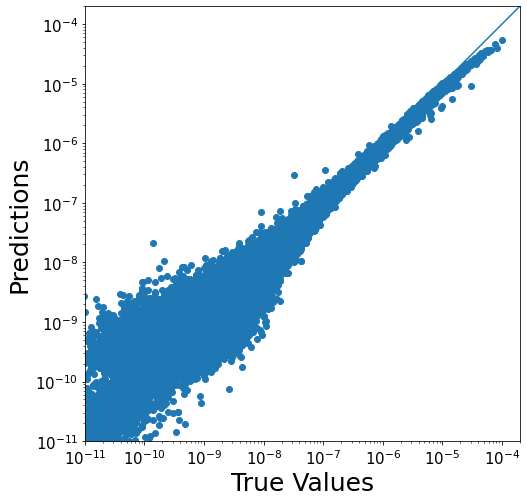

In [89]:
amin, amax = 1e-11, 2e-4

a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict1_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

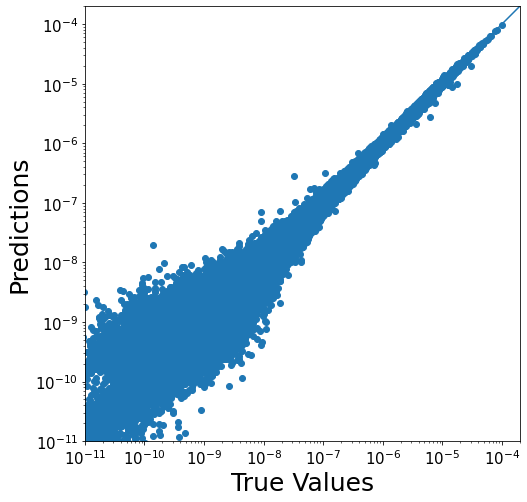

In [90]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict2_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [91]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
   

In [92]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [93]:
features = 'qi, ni, qs, ns, T, rho'
labels   = 'aggr_ice_snow_num, aggr_ice_snow_mass'
filename = 'saved_model_v2/aggr_ice_snow_model1_'+version+'.nc'
logtransform = np.array([True, True, True, True, False, False], dtype=bool)
save2netcdf(model1,features,labels,train_stats3,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/aggr_ice_snow_model1_20.nc
  Features:   qi, ni, qs, ns, T, rho
  Labels:     aggr_ice_snow_num, aggr_ice_snow_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 16), Activation: sigmoid
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 2), Activation: linear


In [94]:
filename = 'saved_model_v2/aggr_ice_snow_model2_'+version+'.nc'
save2netcdf(model2,features,labels,train_stats3,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/aggr_ice_snow_model2_20.nc
  Features:   qi, ni, qs, ns, T, rho
  Labels:     aggr_ice_snow_num, aggr_ice_snow_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 2), Activation: linear


In [95]:
filename = 'saved_model_v2/aggr_ice_snow_model3_'+version+'.nc'
save2netcdf(model3,features,labels,train_stats3,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/aggr_ice_snow_model3_20.nc
  Features:   qi, ni, qs, ns, T, rho
  Labels:     aggr_ice_snow_num, aggr_ice_snow_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 2), Activation: linear


In [96]:
filename = 'saved_model_v2/aggr_ice_snow_model4_'+version+'.nc'
save2netcdf(model4,features,labels,train_stats3,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/aggr_ice_snow_model4_20.nc
  Features:   qi, ni, qs, ns, T, rho
  Labels:     aggr_ice_snow_num, aggr_ice_snow_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 32), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (32, 32), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (32, 32), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (32, 2), Activation: linear
